<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/tutorials/neutron-waveform-extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/main/tutorials/neutron-waveform-extraction.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>


‼️ **Prerequisites** ‼️:
- Access to the `Nucleonics` Google drive folder (it must also be added as a shortcut called "Nucleonics" in your own drive)
- Access to the nucleonics `.env` folder (where sensitive info lives)

# Neutron waveform extraction

This notebook extracts and visualises neutron event waveforms from a ROOT file. It relies on the ["Nuclear particle master"](https://docs.google.com/spreadsheets/d/1zgp8MplLXNAI1s7NAs7tCCVnv7N05AR4Q7x4hnE_PiA/edit?gid=0#gid=0) sheet to provide a PSP threshold value to separate neutrons from gammas. More information about how this PSP value has been calculated can be found in the [PSD Analysis notebook](https://github.com/project-ida/arpa-e-experiments/blob/main/tutorials/PSD-analysis.ipynb).




## Running this notebook

Once you specify the four parameters below, you can run the whole notebook from top to bottom.

- `experiment_id` & `channel_number`: select the experiment metadata row from the master sheet
- `burst_time`: time of the observed neutron burst
- `burst_duration`: time window (in s) around the burst from which we extract the waveforms

You will be asked a couple of time to authenticate with your Google account, but after that all the analysis will happen automatically.

In [6]:
experiment_id = 6
channel_number = 3
burst_time = '2025-06-16 16:19:45'
burst_duration = 60

## Libraries

In [7]:
# Auth
import sys, os
import shutil
from google.colab import drive
from google.colab import auth
from google.auth import default

# Files
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
import os
import gspread

# Data analysis
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sqlalchemy import create_engine, text
from scipy.stats import kstest
! pip install uproot -q
import uproot

#Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go

## Authentication

In [8]:
# Mount Drive
drive.mount('/content/drive')

# Authenticate and create the Drive API client
auth.authenticate_user()
drive_service = build('drive', 'v3')
creds, _ = default()
gc = gspread.authorize(creds)

# Copy SQL credentials from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/psql_credentials_readonly.py", "psql_credentials.py")

# Copy sheet ID file from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/sheet_ids.py", "sheet_ids.py");

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Import SQL credentials
from psql_credentials import PGUSER, PGPASSWORD, PGHOST, PGPORT, PGDATABASE

# Import sheet ID for the nuclear particle master sheet
from sheet_ids import NUCLEAR_PARTICLE_MASTER as sheet_id

# Create the database connection string
connection_uri = f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}'
engine = create_engine(connection_uri)

## Extracting the PSP threshold for neutron discrimination

We need to

- Open the master sheet
- Find the row corresponding with the experiment and channel number:
- Extract the `psp threshold` column

Because the master sheet is organised in blocks that share an experiment ID (to avoid visual overload) we'll need to "fill in" the experiment ID for all rows once the sheet is brought into a pandas dataframe.

In [10]:
# Fill experiment IDs based on the block organisation of the master sheet
def fill_experiment_id(df):
    experiment_id = None
    updated_ids = []

    for index, row in df.iterrows():
        if pd.notna(row['Experiment ID']) and row['Experiment ID'] != '':
            experiment_id = row['Experiment ID']
        updated_ids.append(experiment_id)

    df['Experiment ID'] = updated_ids
    return df

In [11]:
sheet = gc.open_by_key(sheet_id).sheet1

# Read the sheet into a pandas DataFrame
df_sheet = pd.DataFrame(sheet.get_all_records())

# Fill the experiment IDs based on the block organisation of the master sheet
df_sheet = fill_experiment_id(df_sheet)

In [12]:
# Find the row where Experiment ID and channel number match
row = df_sheet[(df_sheet['Experiment ID'] == experiment_id) & (df_sheet['Digitizer channel number'] == channel_number)]

if(len(row) == 0):
  raise RuntimeError("‼️ No row found, check your Experiment ID and Digitizer channel number ‼️ ")

# Extract times
psp_threshold = row.iloc[0]["psp threshold"]

if psp_threshold:
  print(f"PSP threshold: {psp_threshold}")
else:
  print("‼️ PSP threshold not found ‼️ ")

PSP threshold: 0.1484375


## Fetch the ROOT file corresponding to the neutron burst

We now look in the database for the closest ROOT file to the `burst_time`. Since our ROOT files are organised by their end time (time of the last event), we need to look for the closest ROOT file after our specified `burst_time`.

In [13]:
def find_root_file(event_time, channel_number):
    query = """
    SELECT *
    FROM root_files
    WHERE time > %(event_time)s
      AND file LIKE %(file_pattern)s
    ORDER BY ABS(EXTRACT(EPOCH FROM (%(event_time)s - time)))
    LIMIT 1;
    """
    file_pattern = f"%_CH{channel_number}@%"
    df = pd.read_sql(query, con=engine, params={
        "event_time": event_time,
        "file_pattern": file_pattern
    })
    df.set_index('time', inplace=True)
    return df


In [14]:
df_root = find_root_file(burst_time, channel_number)
df_root

,computer,daq_folder,dir,file,id
time,,,,,
2025-06-16 17:08:01,thinkpad-t480s,run4b,caen-nassisi-project-april-2025/DAQ/run4b/RAW,DataR_CH3@DT5730S_31050_run4b_643.root2,279255


Let's create a dictionary for easy access to the file info:

In [15]:
closest_root_file = df_root.iloc[0].to_dict()

Now we need to construct the Google Drive path for this ROOT file to get its ID so that we can download it for use with uproot.

In [16]:
def construct_file_path(root_file):
  return f"/content/drive/MyDrive/Computers/{root_file['computer']}/{root_file['dir']}/{root_file['file']}"

# Function to get file ID from file path
def get_file_id(file_path):
    query = f"name = '{file_path.split('/')[-1]}' and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])
    if items:
        return items[0]['id']
    return None

def download_file_from_drive(file_id, filename):
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
        status, done = downloader.next_chunk()
        print(f"Download {int(status.progress() * 100)}%.")


In [17]:
file_path = construct_file_path(closest_root_file)
file_id = get_file_id(file_path)

In [18]:
filename = closest_root_file["file"]
download_file_from_drive(file_id, filename)

Download 100%.


## Analysing waveform data

### Pulses with absolute time

Each radiation pulse is stored in the ROOT files with a `Timestamp`, `Energy`, `EnergyShort` and `Samples`. The waveform of the pulse is stored in the `Samples` part of the ROOT tree.

`Timestamp` information measures the number of picoseconds from the start of the experiment. In order for us to conveniently extract pulses using absolute time, we will need to create a dataframe with the appropriate time index.

In [19]:
# Opens up the ROOT file and extracts the information
with uproot.open(filename) as f:
    tree = f['Data_R']
    ts = tree['Timestamp'].array(library='np')
    e = tree['Energy'].array(library='np')
    es = tree['EnergyShort'].array(library='np')
    wf = tree['Samples'].array(library='np')

# Creates dataframe with absolute time index
end_time = df_root.index[0]
start_time = end_time - pd.to_timedelta((ts[-1]-ts[0])/1e12, unit='s')
time_abs = start_time + pd.to_timedelta((ts - ts[0])/1e12, unit='s')
df_pulses = pd.DataFrame({'Energy': e, 'EnergyShort': es, 'Waveform': wf}, index=pd.to_datetime(time_abs))

In [20]:
df_pulses.head()

,Energy,EnergyShort,Waveform
2025-06-16 16:05:33.648469387,45,42,"(16167, 16162, 16168, 16170, 16163, 16170, 161..."
2025-06-16 16:05:33.716455296,226,204,"(16165, 16166, 16170, 16166, 16167, 16169, 161..."
2025-06-16 16:05:33.781905502,102,94,"(16165, 16170, 16167, 16173, 16167, 16164, 161..."
2025-06-16 16:05:33.961957002,170,154,"(16165, 16168, 16165, 16171, 16166, 16166, 161..."
2025-06-16 16:05:33.972274893,479,426,"(16156, 16164, 16162, 16168, 16167, 16166, 161..."


### Extracting only neutron pulses

Currently the `df_pulses` datafarme contains gammas and neutrons. The most accurate way to discriminate between gammas and neutrons is to create a fiducial lines. For the purpose of inspecting the waveforms to see whether a burst is physical of just electrical noise, a simple threshold PSP value is good enough. More discussion of this can be found in the [PSD Analysis notebook](https://github.com/project-ida/arpa-e-experiments/blob/main/tutorials/PSD-analysis.ipynb).

PSP is calculated by:

$$
\rm PSP = \frac{\rm Energy - EnergyShort}{\rm Energy}
$$

A neutron pulse is then defined as a pulse whose PSP is greater than the threshold pulled in from the master sheet.


In [21]:
# Filtering out gammas to retain only neutrons
df_pulses['PSP'] = 1 - (df_pulses['EnergyShort'] / df_pulses['Energy'])

if psp_threshold:
  neutrons = df_pulses[df_pulses['PSP'] > psp_threshold]
else:
  print("‼️ PSP threshold not found ‼️ ")

### Visualising the counts

Let's now do a sanity check and visualise the counts per second over the entire ROOT file. The plot below should look identical to what we see in our data panels.

We'll also mark the burst time:

In [22]:
burst_time = pd.to_datetime(burst_time)
print(burst_time)

2025-06-16 16:19:45


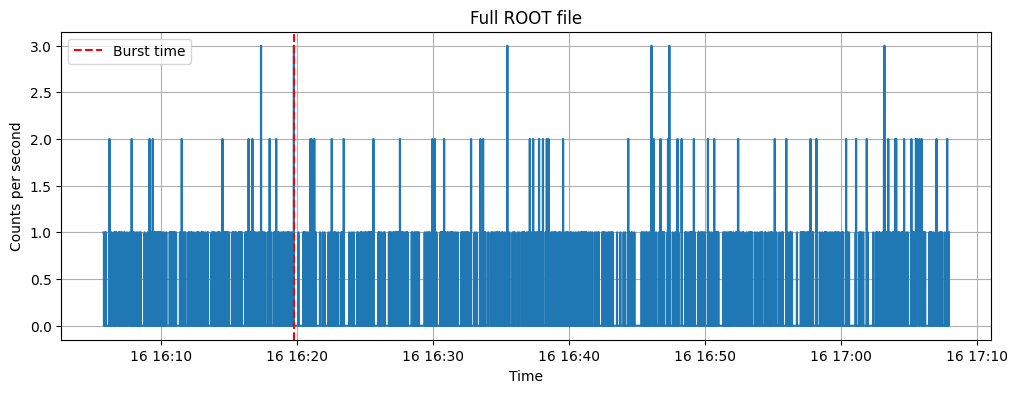

In [23]:
if psp_threshold:
  cps = neutrons['PSP'].resample('1s').count()
  plt.figure(figsize=(12, 4))
  plt.plot(cps, drawstyle='steps-mid')
  plt.axvline(burst_time, color='r', linestyle='--', label="Burst time")
  plt.title('Full ROOT file')
  plt.xlabel('Time')
  plt.ylabel('Counts per second')
  plt.legend()
  plt.grid(True)
  plt.show()
else:
  print("‼️ PSP threshold not found ‼️ ")

Let's now zoom in on the burst. Recall that our burst is defined as a time period centred on:

In [24]:
print(burst_time)

2025-06-16 16:19:45


with a duration of:

In [25]:
burst_duration = pd.to_timedelta(burst_duration, unit='s')
print(burst_duration)

0 days 00:01:00


Once we determine the `burst_start` and `burst_end` times, we can easily pull out cps and waveforms for the burst.

In [26]:
burst_start = burst_time - burst_duration/2
burst_end = burst_time + burst_duration/2

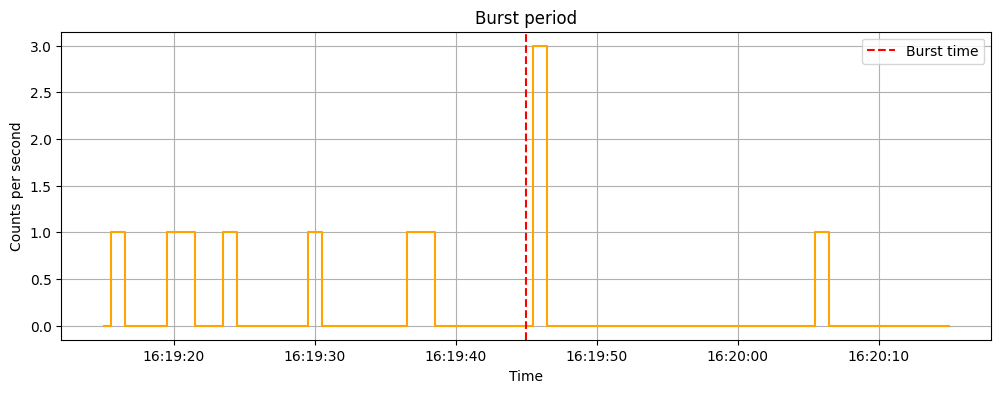

In [27]:
if psp_threshold:
  plt.figure(figsize=(12, 4))
  plt.plot(cps[burst_start:burst_end], drawstyle='steps-mid', color='orange')
  plt.axvline(burst_time, color='r', linestyle='--', label="Burst time")
  plt.title('Burst period')
  plt.xlabel('Time')
  plt.ylabel('Counts per second')
  plt.legend()
  plt.grid(True)
  plt.show()
else:
  print("‼️ PSP threshold not found ‼️ ")

### Visualising the waveforms

We can now easily extract the visualise the neutron waveforms for the burst using the `burst_start` and `burst_end` times.

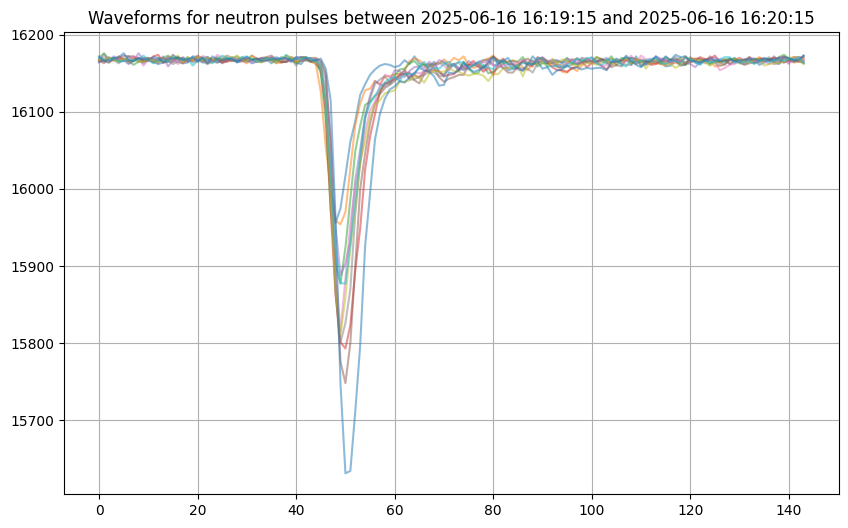

In [28]:
if psp_threshold:
  df_burst = neutrons[burst_start:burst_end]
  plt.figure(figsize=(10, 6))
  for wf in df_burst['Waveform']:
      plt.plot(wf, alpha=0.5)
  plt.title(f'Waveforms for neutron pulses between {burst_start} and {burst_end}')
  plt.grid(True)
  plt.show()
else:
  print("‼️ PSP threshold not found ‼️ ")